In [2]:
%load_ext rpy2.ipython

In [32]:
%%R
# Add libraries and functions
library(gsignal)
library(eyeris)
library(dplyr)
source("../../src/riskyneuroarousal/preprocessing/remove_gaze_regressor.R")
source("../../src/riskyneuroarousal/preprocessing/load_data.R")
source("../../src/riskyneuroarousal/preprocessing/add_nan_descriptors.R")
source("../../src/riskyneuroarousal/preprocessing/replace_out_of_bounds.R")

library(eyelinker)
library(stringr)

In [ ]:
%%R
library(stringr)
library(dplyr)
library(eyelinker)
source("../../src/riskyneuroarousal/preprocessing/valid_subs.R")


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [4]:
%%R
# Define input and output directories
home_dir <- "/Users/gustxsr/Documents/Stanford/PoldrackLab/PAPERS/paper1_loss_aversion_pupil/eye_data"
input_dir <- paste(home_dir, "NARPS_MG_asc", sep = "/")
output_dir <- paste(home_dir, "NARPS_MG_asc_processed", sep = "/")
quality_control_dir <- paste(home_dir,
                             "NARPS_MG_asc_quality_control", sep = "/")

# Ensure the output directory exists
if (!dir.exists(output_dir)) {
  dir.create(output_dir)
}

# Ensure the quality control directory exists
if (!dir.exists(quality_control_dir)) {
  dir.create(quality_control_dir)
}

# Process all .asc files in the input directory
asc_files <- list.files(input_dir, pattern = "\\.asc$", full.names = TRUE)

for (file in asc_files[9:12]) {
  # Load the data
  subject_id <- stringr::str_extract(file, "sub-\\d{3}")
  run_id <- stringr::str_extract(file, "run-\\d")
  if (!(subject_id %in% valid_subs)) {
    cat("Skipping subject ", subject_id, " as it is not in the valid list.\n")
    next
  }

  loaded_data <- read.asc(file)

  # Valid saccade end times
  sacc_events <- loaded_data$sacc$etime[loaded_data$sacc$exp > 1920/2 - 500 & loaded_data$sacc$exp < 1920/2 + 500 & loaded_data$sacc$eyp > 1080/2 - 250 & loaded_data$sacc$eyp < 1080/2 + 250]

  # Saccade blinks
  blink_events <- loaded_data$blinks$etime + 100

  # Start times
  trial_starts <- loaded_data$msg %>%
    filter(str_detect(text, "flag_TrialStart")) %>%
    mutate(
        trial = str_extract(text, "Trial\\d+") %>% str_remove("Trial") %>% as.integer(),
        start_time = time
    ) %>%
    select(block, trial, start_time)

  # Response
  responses <- loaded_data$msg %>%
    filter(str_detect(text, "flag_Response")) %>%
    mutate(
        trial = str_extract(text, "Trial\\d+") %>% str_remove("Trial") %>% as.integer(),
        response_time = time
    ) %>%
    select(block, trial, response_time)

  # Durations
  trial_durations <- trial_starts %>%
    inner_join(responses, by = c("block", "trial")) %>%
    mutate(duration = response_time - start_time)

  # Save each event type to a separate file csv (using run_id in filename)
  write.csv(sacc_events, file = paste0(output_dir, "/", subject_id, "_", run_id, "_saccades.csv"), row.names = FALSE)
  write.csv(blink_events, file = paste0(output_dir, "/", subject_id, "_", run_id, "_blinks.csv"), row.names = FALSE)
  write.csv(trial_starts, file = paste0(output_dir, "/", subject_id, "_", run_id, "_trial_starts.csv"), row.names = FALSE)
  write.csv(responses, file = paste0(output_dir, "/", subject_id, "_", run_id, "_responses.csv"), row.names = FALSE)
  write.csv(trial_durations, file = paste0(output_dir, "/", subject_id, "_", run_id, "_trial_durations.csv"), row.names = FALSE)

}

In [9]:
%%R
file <- "/Users/gustxsr/Documents/Stanford/PoldrackLab/github/riskyneuroarousal/data/sub-003_run-1.asc"
valid_subs <- c("sub-003")

# Load the data
loaded_data <- load_data(file, valid_subs)

# Make the data items available in the global environment
data <- loaded_data$data
subject_id <- loaded_data$subject_id
run_id <- loaded_data$run_id
subject_num <- loaded_data$subject_num
run_num <- loaded_data$run_num

[1] "Processing sub-003 run-1"


In [45]:
%%R
otherdata <- read.asc(file)

In [49]:
%%R
str(otherdata$msg)

tibble [130 × 3]

 (S3: tbl_df/tbl/data.frame)
 $ block: num [1:130] 1 1 1 1 1 1 1 1 1 1 ...
 $ time : num [1:130] 627855 627934 627969 629226 632947 ...
 $ text : chr [1:130] "!MODE RECORD CR 500 2 1 R" "flag_RunStart_TaskMGT_Run001_Trial001_Time0.015763" "flag_TrialStart_TaskMGT_Run001_Trial001_Time0.052579" "flag_Response_TaskMGT_Run001_Trial001_Time1.3105" ...


In [46]:
%%R
# Step 1: Filter TrialStart and Response events
trial_starts <- otherdata$msg %>%
  filter(str_detect(text, "flag_TrialStart")) %>%
  mutate(
    trial = str_extract(text, "Trial\\d+") %>% str_remove("Trial") %>% as.integer(),
    start_time = time
  ) %>%
  select(block, trial, start_time)

In [40]:
%%R
responses <- otherdata$msg %>%
  filter(str_detect(text, "flag_Response")) %>%
  mutate(
    trial = str_extract(text, "Trial\\d+") %>% str_remove("Trial") %>% as.integer(),
    response_time = time
  ) %>%
  select(block, trial, response_time)

In [42]:
%%R
# Step 2: Join and compute duration
trial_durations <- trial_starts %>%
  inner_join(responses, by = c("block", "trial")) %>%
  mutate(duration = response_time - start_time)

In [43]:
%%R
trial_durations

# A tibble: 63 × 5
   block trial start_time response_time duration
   <dbl> <int>      <dbl>         <dbl>    <dbl>
 1     1     1     627969        629226     1257
 2     1     2     632947        633991     1044
 3     1     3     638548        641353     2805
 4     1     4     644051        644989      938
 5     1     5     649451        650595     1144
 6     1     6     655151        656298     1147
 7     1     7     660934        661977     1043
 8     1     8     670034        671389     1355
 9     1     9     675135        677427     2292
10     1    10     682036        683079     1043
# ℹ 53 more rows
# ℹ Use `print(n = ...)` to see more rows


In [44]:
%%R
trial_starts

# A tibble: 64 × 3
   block trial start_time
   <dbl> <int>      <dbl>
 1     1     1     627969
 2     1     2     632947
 3     1     3     638548
 4     1     4     644051
 5     1     5     649451
 6     1     6     655151
 7     1     7     660934
 8     1     8     670034
 9     1     9     675135
10     1    10     682036
# ℹ 54 more rows
# ℹ Use `print(n = ...)` to see more rows


In [28]:
%%R
# (5) Remove the gaze regressor
data <- remove_gaze_regressor(data)
mean_pupil_size <- mean(data$timeseries$pupil_raw, na.rm = TRUE)
# (3) Replace out of bounds values with NA
data <- replace_out_of_bounds(data, 
                              focus_screen_width = 1000,
                              focus_screen_height = 500)

# (4) Add indicator variables for blink and out of bounds
data <- add_nan_descriptors(data)

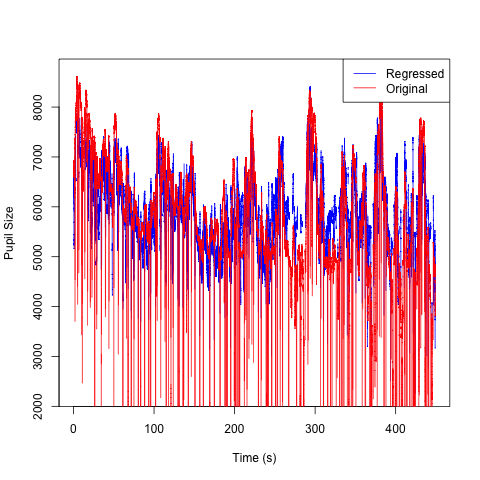

In [30]:
%%R
# Plot to compare how the data looks
time <- data$timeseries$time_orig
# convert to seconds, starting at 0
time <- (time - time[1]) / 1000

# plot pupil_raw and pupil_raw_orig
plot(time, data$timeseries$pupil_raw, type="l", col="blue", xlab="Time (s)", ylab="Pupil Size")
lines(time, data$timeseries$pupil_raw_orig, col="red")
legend("topright", legend=c("Regressed", "Original"), col=c("blue", "red"), lty=1)


In [31]:
%%R
eye_preproc <- (eyeris::deblink(data, extend = 100) |> 
                eyeris::detransient(n = 16) |> 
                eyeris::interpolate() |> 
                eyeris::lpfilt(wp = 0.025, ws = 0.05, rp = 1, rs = 35))

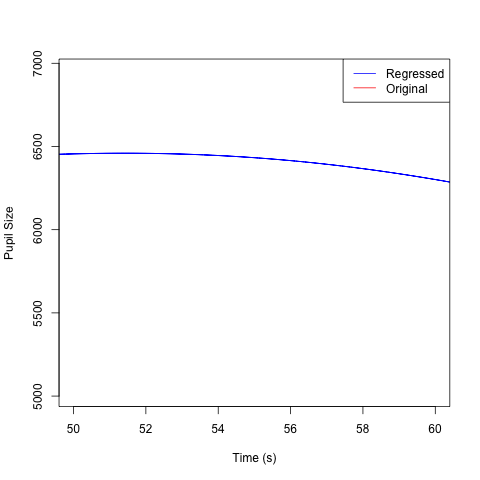

In [32]:
%%R
time <- eye_preproc$timeseries$time_orig
# convert to seconds, starting at 0
time <- (time - time[1]) / 1000
# plot pupil_raw and pupil_raw_orig
plot(time, eye_preproc$timeseries$pupil_raw_deblink_detransient_interpolate_lpfilt, type="l", col="blue", xlab="Time (s)", ylab="Pupil Size", xlim=c(50, 60))
# lines(time, eye_preproc$timeseries$pupil_raw_deblink_detransient_interpolate_lpfilt, col="red")
legend("topright", legend=c("Regressed", "Original"), col=c("blue", "red"), lty=1)

In [34]:
%%R
# Bandpass filter the data
fs <- eye_preproc$info$sample.rate
fpass <- c(0.02, 4)
wpass <- fpass / (fs / 2)
but <- gsignal::butter(2, wpass, "pass")
eye_preproc$timeseries$pupil_raw_deblink_detransient_interpolate_lpfilt <- gsignal::filtfilt(but, eye_preproc$timeseries$pupil_raw_deblink_detransient_interpolate) + mean_pupil_size

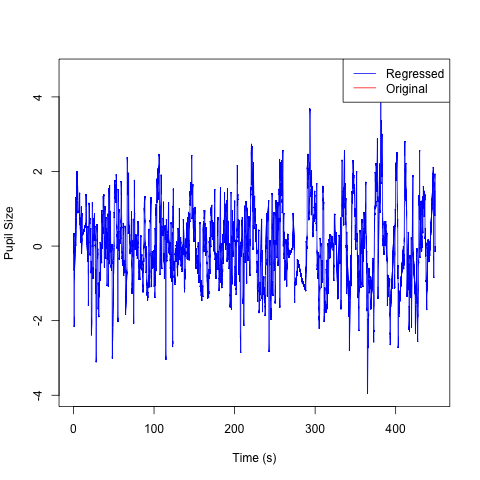

In [38]:
%%R
time <- eye_preproc$timeseries$time_orig
# convert to seconds, starting at 0
time <- (time - time[1]) / 1000
# plot pupil_raw and pupil_raw_orig
plot(time, eye_preproc$timeseries$pupil_raw_deblink_detransient_interpolate_lpfilt, type="l", col="blue", xlab="Time (s)", ylab="Pupil Size")
# lines(time, eye_preproc$timeseries$pupil_raw_deblink_detransient_interpolate_lpfilt, col="red")
legend("topright", legend=c("Regressed", "Original"), col=c("blue", "red"), lty=1)

In [1]:
%%R
eye_preproc <- eyeris::zscore(eye_preproc)

UsageError: Cell magic `%%R` not found.


In [ ]:
%%R
# timeseries we want to save is eye_preproc$timeseries$pupil_raw_deblink_detransient_interpolate_lpfilt_z
# Now we want to create a list of events and durations


In [ ]:
%%R
eye_preproc$timeseries$pupil_raw_deblink_detransient_interpolate_lpfilt_z

    [1] -6.650351e-01 -6.502448e-01 -6.352777e-01 -6.201503e-01 -6.048794e-01
    [6] -5.894822e-01 -5.739755e-01 -5.583758e-01 -5.426988e-01 -5.269594e-01
   [11] -5.111717e-01 -4.953493e-01 -4.795051e-01 -4.636512e-01 -4.477990e-01
   [16] -4.319591e-01 -4.161402e-01 -4.003496e-01 -3.845927e-01 -3.688731e-01
   [21] -3.531926e-01 -3.375518e-01 -3.219495e-01 -3.063840e-01 -2.908531e-01
   [26] -2.753548e-01 -2.598873e-01 -2.444493e-01 -2.290402e-01 -2.136598e-01
   [31] -1.983088e-01 -1.829887e-01 -1.677016e-01 -1.524509e-01 -1.372411e-01
   [36] -1.220775e-01 -1.069670e-01 -9.191731e-02 -7.693709e-02 -6.203536e-02
   [41] -4.722136e-02 -3.250453e-02 -1.789455e-02 -3.401467e-03  1.096418e-02
   [46]  2.519128e-02  3.926813e-02  5.318231e-02  6.692068e-02  8.046933e-02
   [51]  9.381358e-02  1.069379e-01  1.198261e-01  1.324612e-01  1.448252e-01
   [56]  1.568994e-01  1.686649e-01  1.801022e-01  1.911923e-01  2.019162e-01
   [61]  2.122554e-01  2.221915e-01  2.317065e-01  2.407829e-01 

Exception ignored from cffi callback <function _consolewrite_ex at 0x10f796c00>:
Traceback (most recent call last):
  File "/Users/gustxsr/Documents/Stanford/PoldrackLab/github/riskyneuroarousal/.venv/lib/python3.12/site-packages/rpy2/rinterface_lib/callbacks.py", line 140, in _consolewrite_ex
    consolewrite_print(s)
  File "/Users/gustxsr/Documents/Stanford/PoldrackLab/github/riskyneuroarousal/.venv/lib/python3.12/site-packages/rpy2/rinterface_lib/callbacks.py", line 122, in consolewrite_print
    print(s, end='', flush=True)
  File "/Users/gustxsr/Documents/Stanford/PoldrackLab/github/riskyneuroarousal/.venv/lib/python3.12/site-packages/ipykernel/iostream.py", line 694, in write
    self._schedule_flush()
  File "/Users/gustxsr/Documents/Stanford/PoldrackLab/github/riskyneuroarousal/.venv/lib/python3.12/site-packages/ipykernel/iostream.py", line 590, in _schedule_flush
    self.pub_thread.schedule(_schedule_in_thread)
  File "/Users/gustxsr/Documents/Stanford/PoldrackLab/github/ris

  9.074684e-01
 [3571]  9.080272e-01  9.086273e-01  9.092700e-01  9.099569e-01  9.106896e-01
 [3576]  9.114694e-01  9.122979e-01  9.131766e-01  9.141069e-01  9.150902e-01
 [3581]  9.161278e-01  9.172212e-01  9.183716e-01  9.195802e-01  9.208482e-01
 [3586]  9.221768e-01  9.235669e-01  9.250195e-01  9.265355e-01  9.281156e-01
 [3591]  9.297605e-01  9.314706e-01  9.332464e-01  9.350881e-01  9.369958e-01
 [3596]  9.389694e-01  9.410087e-01  9.431133e-01  9.452825e-01  9.475154e-01
 [3601]  9.498111e-01  9.521684e-01  9.545859e-01  9.570623e-01  9.595958e-01
 [3606]  9.621849e-01  9.648276e-01  9.675216e-01  9.702649e-01  9.730547e-01
 [3611]  9.758885e-01  9.787634e-01  9.816761e-01  9.846235e-01  9.876021e-01
 [3616]  9.906089e-01  9.936406e-01  9.966943e-01  9.997668e-01  1.002855e+00
 [3621]  1.005957e+00  1.009070e+00  1.012192e+00  1.015321e+00  1.018457e+00
 [3626]  1.021601e+00  1.024752e+00  1.027913e+00  1.031084e+00  1.034269e+00
 [3631]  1.037468e+00  1.040685e+00  1.043922e+00

In [59]:
%%R
# Define target sampling rate
target_hz <- 50
original_hz <- eye_preproc$info$sample.rate
resample_factor <- original_hz / target_hz

eye_preproc$timeseries <- eye_preproc$timeseries %>%
mutate(bin = ceiling(row_number() / resample_factor)) %>%
group_by(bin) %>%
summarise(
# Apply mean to specific columns
eye_x = mean(eye_x, na.rm = TRUE),
eye_y = mean(eye_y, na.rm = TRUE),


# Apply median to specific columns
pupil_raw = median(pupil_raw, na.rm = TRUE),
pupil_raw_deblink = median(pupil_raw_deblink, na.rm = TRUE),
pupil_raw_deblink_detransient = median(pupil_raw_deblink_detransient, na.rm = TRUE),
pupil_raw_deblink_detransient_interpolate = median(pupil_raw_deblink_detransient_interpolate, na.rm = TRUE),
pupil_raw_deblink_detransient_interpolate_lpfilt = median(pupil_raw_deblink_detransient_interpolate_lpfilt, na.rm = TRUE),
pupil_raw_deblink_detransient_interpolate_lpfilt_z = median(pupil_raw_deblink_detransient_interpolate_lpfilt_z, na.rm = TRUE),
#pupil_raw_deblink_detransient_interpolate_lpfilt_detrend_poly = median(pupil_raw_deblink_detransient_interpolate_lpfilt_detrend_poly, na.rm = TRUE),

# Pick a single value (first row in each bin)
time_orig = first(time_orig),
eye = first(eye),
hz = first(hz),
type = first(type),
blink = first(blink),
outofbounds = first(outofbounds),

.groups = "drop"
)

eye_preproc$info$sample.rate <- 50
eye_preproc$timeseries$hz <- 50

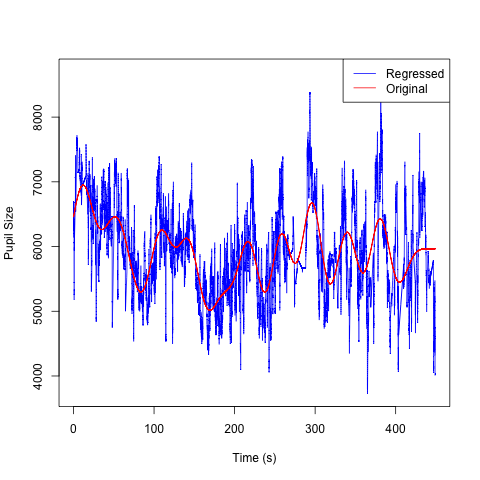

In [35]:
%%R
# Plot to compare how the data looks
time <- eye_preproc$timeseries$time_orig
# convert to seconds, starting at 0
time <- (time - time[1]) / 1000

# plot pupil_raw and pupil_raw_orig
plot(time, eye_preproc$timeseries$pupil_raw_deblink_detransient_interpolate, type="l", col="blue", xlab="Time (s)", ylab="Pupil Size")
lines(time, eye_preproc$timeseries$pupil_raw_deblink_detransient_interpolate_lpfilt, col="red")
legend("topright", legend=c("Regressed", "Original"), col=c("blue", "red"), lty=1)

In [60]:
%%R
# (9) Epoch the data and compute baseline pupil size for trials
eye_preproc <- eyeris::epoch(eye_preproc, events = "flag_TrialStart*", calc_baseline = TRUE, apply_baseline = FALSE, baseline_events = "flag_TrialStart*", baseline_period = c(-0.5, 0), limits = c(0, 4))
# eye_preproc <- eyeris::epoch(eye_preproc, events = "flag_Response*", calc_baseline = FALSE, apply_baseline = FALSE, limits = c(-1.5, 1.5))
# eye_preproc$epoch_flagTrialstart$trial <- as.numeric(gsub(".*_Trial(\\d+)_.*", "\\1", eye_preproc$epoch_flagTrialstart$matched_event))
# eye_preproc$epoch_flagResponse$trial <- as.numeric(gsub(".*_Trial(\\d+)_.*", "\\1", eye_preproc$epoch_flagResponse$matched_event))

In [63]:
%%R
names(eye_preproc)

[1] "file"                                                                                        
[2] "timeseries"                                                                                  
[3] "events"                                                                                      
[4] "blinks"                                                                                      
[5] "info"                                                                                        
[6] "latest"                                                                                      
[7] "params"                                                                                      
[8] "baseline_pupil_raw_deblink_detransient_interpolate_lpfilt_z_sub_bl_corr_epoch_flagTrialstart"
[9] "epoch_flagTrialstart"                                                                        


In [65]:
%%R
baseline <- eye_preproc$baseline_pupil_raw_deblink_detransient_interpolate_lpfilt_z_sub_bl_corr_epoch_flagTrialstart$baseline_means_by_epoch


In [67]:
%%R
# trial_num is from 1 to len(baseline)
trial_num <- 1:length(baseline)

In [69]:
%%R
trial_num + 64

 [1]  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83
[20]  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102
[39] 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121
[58] 122 123 124 125 126 127 128


In [43]:
%%R
eye_preproc$baseline_pupil_raw_deblink_detransient_interpolate_lpfilt_sub_bl_corr_epoch_flagTrialstart$baseline_means_by_epoch

 [1] 6457.515 6754.512 6939.075 6890.224 6677.682 6423.492 6276.245 6336.985
 [9] 6425.871 6446.165 6162.687 5629.643 5375.322 5321.506 5614.762 5991.471
[17] 6223.370 6222.662 6037.090 6000.216 6070.047 6101.504 5888.688 5296.957
[25] 5023.940 5042.797 5170.810 5293.686 5356.662 5550.171 5896.499 6070.559
[33] 5977.790 5489.301 5295.647 5466.032 5781.990 6119.211 6107.576 5838.549
[41] 5810.879 6293.825 6662.302 6317.398 5693.301 5422.683 5560.604 5904.399
[49] 6204.454 6164.038 5950.943 5673.341 5597.726 5753.500 6077.946 6357.274
[57] 6317.561 5960.257 5624.085 5461.014 5687.797 5881.786 5943.729 5964.398


In [39]:
%%R
str(eye_preproc$epoch_flagTrialstart)

tibble [12,800 × 21] (S3: tbl_df/tbl/data.frame)
 $ bin                                             : num [1:12800] 7 8 9 10 11 12 13 14 15 16 ...
 $ eye_x                                           : num [1:12800] 964 964 963 964 964 ...
 $ eye_y                                           : num [1:12800] 506 504 508 517 515 ...
 $ pupil_raw                                       : num [1:12800] 6694 6700 6703 6591 6591 ...
 $ pupil_raw_deblink                               : num [1:12800] 6694 6700 6703 6591 6591 ...
 $ pupil_raw_deblink_detransient                   : num [1:12800] 6695 6700 6705 6591 6591 ...
 $ pupil_raw_deblink_detransient_interpolate       : num [1:12800] 6696 6700 6684 6591 6591 ...
 $ pupil_raw_deblink_detransient_interpolate_lpfilt: num [1:12800] 6462 6464 6465 6466 6468 ...
 $ time_orig                                       : int [1:12800] 627975 627995 628015 628035 628055 628075 628095 628115 628135 628155 ...
 $ timebin                                        

In [23]:
%%R
eye_preproc$epoch_flagTrialstart$baseline <- eye_preproc$baseline_pupil_raw_deblink_detransient_interpolate_lpfilt_sub_bl_corr_epoch_flagTrialstart$baseline_means_by_epoch[eye_preproc$epoch_flagTrialstart$trial]
eye_preproc$epoch_flagResponse$baseline <- eye_preproc$baseline_pupil_raw_deblink_detransient_interpolate_lpfilt_sub_bl_corr_epoch_flagTrialstart$baseline_means_by_epoch[eye_preproc$epoch_flagResponse$trial]
eye_preproc$epoch_flagTrialstart$ps_preprocessed <- (eye_preproc$epoch_flagTrialstart$pupil_raw_deblink_detransient_interpolate_lpfilt - eye_preproc$epoch_flagTrialstart$baseline) / (eye_preproc$epoch_flagTrialstart$baseline + mean_pupil_size)
eye_preproc$epoch_flagResponse$ps_preprocessed <- (eye_preproc$epoch_flagResponse$pupil_raw_deblink_detransient_interpolate_lpfilt - eye_preproc$epoch_flagResponse$baseline) / (eye_preproc$epoch_flagResponse$baseline + mean_pupil_size)

In [24]:
%%R
eye_preproc$epoch_flagTrialstart$sub <- subject_num
eye_preproc$epoch_flagResponse$sub <- subject_num
eye_preproc$epoch_flagTrialstart$trial <- eye_preproc$epoch_flagTrialstart$trial + (run_num-1) * 64
eye_preproc$epoch_flagResponse$trial <- eye_preproc$epoch_flagResponse$trial + (run_num-1) * 64


# (10) Select the relevant columns to save
output_data <- eye_preproc$epoch_flagTrialstart %>%
    select(sub, timebin, trial, ps_preprocessed, blink, outofbounds)

output_data2 <- eye_preproc$epoch_flagResponse %>%
    select(sub, timebin, trial, ps_preprocessed, blink, outofbounds)

In [32]:
%%R
data_summary <- output_data %>%
  group_by(trial) %>%
  summarise(mean_blink = mean(blink, na.rm = TRUE)) %>%
  filter(mean_blink <= 0.5) %>%
  select(trial)

filtered_data <- output_data %>%
  semi_join(data_summary, by = "trial")

In [36]:
%%R
filtered_summary <- filtered_data %>%
  group_by(timebin) %>%
  summarise(mean_ps = mean(ps_preprocessed, na.rm = TRUE))